# Fitting by least square
In this notebook we consider  set of bands of the Lent-model closest near the Fermi-level, up to the first six. We compare these bands with the bands of the Hsieh model by an Python built-in least square fit.

In [2]:
import numpy as np
import qsymm
import math
from scipy.linalg import block_diag
from numpy import linalg as LA
from numpy import ndarray
import matplotlib.pyplot as plt
import time
from scipy.optimize import curve_fit
from scipy.optimize import least_squares

## The Lent model

In [3]:
def H(self): # Easier way to compute Hermitian conjugate
    return self.conj().T

def Lent(esc, esa, epc, epa, edc, eda, lambdac, lambdaa, vss, vsp, vps, vpp, vpppi, vpd, vpdpi, vdp, vdppi, vdd, vdddelta, vddpi, kx, ky, kz, a):
    
    g0 = 2*(math.cos(kx*a) + math.cos(ky*a) + math.cos(kz*a))
    g1 = 1j*math.sin(kx*a)
    g2 = 1j*math.sin(ky*a)
    g3 = 1j*math.sin(kz*a)
    g4 = math.cos(kx*a)
    g5 = math.cos(ky*a)
    g6 = math.cos(kz*a)
    
    vxx = 2*g4*vpp + 2*(g5 + g6)*vpppi
    vyy = 2*g5*vpp + 2*(g4 + g6)*vpppi
    vzz = 2*g6*vpp + 2*(g4 + g5)*vpppi
    
    Hss  = np.array([[esc, 0, g0*vss, 0],
                     [0, esc, 0, g0*vss],
                     [g0*vss, 0, esa, 0],
                     [0, g0*vss, 0, esa]])
    Hpcs = np.array([[0, 0, -2*g1*vps, 0],
                     [0, 0, -2*g2*vps, 0],
                     [0, 0, -2*g3*vps, 0],
                     [0, 0, 0, -2*g1*vps],
                     [0, 0, 0, -2*g2*vps],
                     [0, 0, 0, -2*g3*vps]])
    Hpas = np.array([[-2*g1*vsp, 0, 0, 0],
                     [-2*g2*vsp, 0, 0, 0],
                     [-2*g3*vsp, 0, 0, 0],
                     [0, -2*g1*vsp, 0, 0],
                     [0, -2*g2*vsp, 0, 0],
                     [0, -2*g3*vsp, 0, 0]])
    Hpcpc = np.array([[epc, -1j*lambdac/2, 0, 0, 0, lambdac/2],
                     [1j*lambdac/2, epc, 0, 0, 0, -1j*lambdac/2],
                     [0, 0, epc, -lambdac/2, 1j*lambdac/2, 0],
                     [0, 0, -lambdac/2, epc, 1j*lambdac/2, 0],
                     [0, 0, -1j*lambdac/2, -1j*lambdac/2, epc, 0],
                     [lambdac/2, 1j*lambdac/2, 0, 0, 0, epc]])
    Hpapa = np.array([[epa, -1j*lambdaa/2, 0, 0, 0, lambdaa/2],
                     [1j*lambdaa/2, epa, 0, 0, 0, -1j*lambdaa/2],
                     [0, 0, epa, -lambdaa/2, 1j*lambdaa/2, 0],
                     [0, 0, -lambdaa/2, epa, 1j*lambdaa/2, 0],
                     [0, 0, -1j*lambdaa/2, -1j*lambdaa/2, epa, 0],
                     [lambdaa/2, 1j*lambdaa/2, 0, 0, 0, epa]])
    Hpapc = np.array([[vxx, 0, 0, 0, 0, 0],
                      [0, vyy, 0, 0, 0, 0],
                      [0, 0, vzz, 0, 0, 0],
                      [0, 0, 0, vxx, 0, 0],
                      [0, 0, 0, 0, vyy, 0],
                      [0, 0, 0, 0, 0, vzz]])
    Hdapc = np.array([[-np.sqrt(3)*g1*vpd, np.sqrt(3)*g2*vpd, 0, 0, 0, 0],
                      [g1*vpd, g2*vpd, -2*g3*vpd, 0, 0, 0],
                      [-2*g2*vpdpi, -2*g1*vpdpi, 0, 0, 0, 0],
                      [0, -2*g3*vpdpi, -2*g2*vpdpi, 0, 0, 0],
                      [-2*g3*vpdpi, 0, -2*g1*vpdpi, 0, 0, 0],
                      [0, 0, 0, -np.sqrt(3)*g1*vpd, np.sqrt(3)*g2*vpd, 0],
                      [0, 0, 0, g1*vpd, g2*vpd, -2*g3*vpd],
                      [0, 0, 0, -2*g2*vpdpi, -2*g1*vpdpi, 0],
                      [0, 0, 0, 0, -2*g3*vpdpi, -2*g2*vpdpi],
                      [0, 0, 0, -2*g3*vpdpi, 0, -2*g1*vpdpi]])
    Hdcpa = np.array([[-np.sqrt(3)*g1*vdp, np.sqrt(3)*g2*vdp, 0, 0, 0, 0],
                      [g1*vdp, g2*vdp, -2*g3*vdp, 0, 0, 0],
                      [-2*g2*vdppi, -2*g1*vdppi, 0, 0, 0, 0],
                      [0, -2*g3*vdppi, -2*g2*vdppi, 0, 0, 0],
                      [-2*g3*vdppi, 0, -2*g1*vdppi, 0, 0, 0],
                      [0, 0, 0, -np.sqrt(3)*g1*vdp, np.sqrt(3)*g2*vdp, 0],
                      [0, 0, 0, g1*vdp, g2*vdp, -2*g3*vdp],
                      [0, 0, 0, -2*g2*vdppi, -2*g1*vdppi, 0],
                      [0, 0, 0, 0, -2*g3*vdppi, -2*g2*vdppi],
                      [0, 0, 0, -2*g3*vdppi, 0, -2*g1*vdppi]])
    Hdadc = np.array([[3/2*(g4 + g5)*vdd + (2*g6 + g4/2 + g5/2)*vdddelta, np.sqrt(3)/2*(g5 - g4)*(vdd - vdddelta), 0, 0, 0, 0, 0, 0, 0, 0],
                      [np.sqrt(3)/2*(g5 - g4)*(vdd - vdddelta), 3/2*(g4 + g5)*vdddelta + (2*g6 + g4/2 + g5/2)*vdd, 0, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 2*(g4 + g5)*vddpi + 2*g6*vdddelta, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 2*(g5 + g6)*vddpi + 2*g4*vdddelta, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 2*(g4 + g6)*vddpi + 2*g5*vdddelta, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 3/2*(g4 + g5)*vdd + (2*g6 + g4/2 + g5/2)*vdddelta, np.sqrt(3)/2*(g5 - g4)*(vdd - vdddelta), 0, 0, 0],
                      [0, 0, 0, 0, 0, np.sqrt(3)/2*(g5 - g4)*(vdd - vdddelta), 3/2*(g4 + g5)*vdddelta + (2*g6 + g4/2 + g5/2)*vdd, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 2*(g4 + g5)*vddpi + 2*g6*vdddelta, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0, 2*(g5 + g6)*vddpi + 2*g4*vdddelta, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 2*(g4 + g6)*vddpi + 2*g5*vdddelta]])
    Hdcdc = np.diag([edc, edc, edc, edc, edc, edc, edc, edc, edc, edc])
    Hdada = np.diag([eda, eda, eda, eda, eda, eda, eda, eda, eda, eda])
    
    ham = np.vstack((
        np.hstack((Hss, H(Hpcs), H(Hpas), np.zeros((4, 10)), np.zeros((4,10)))),
        np.hstack((Hpcs, Hpcpc, H(Hpapc), np.zeros((6, 10)), H(Hdapc))),
        np.hstack((Hpas, Hpapc, Hpapa, H(Hdcpa), np.zeros((6, 10)))),
        np.hstack((np.zeros((10, 4)), np.zeros((10, 6)), Hdcpa, Hdcdc, H(Hdadc))),
        np.hstack((np.zeros((10, 4)), Hdapc, np.zeros((10, 6)), Hdadc, Hdada))
    ))
    return ham
    #return H(Hdapc)
    #return Hdcpa

esc = -6.578
esa = -12.067
epc = 1.659
epa = -0.167
edc = 8.38
eda = 7.73
lambdac = 0.592
lambdaa = 0.564
vss = -0.510
vsp = 0.949
vps = -0.198
vpp = 2.218
vpppi = -0.446
vpd = -1.11
vpdpi = 0.624
vdp = -1.67
vdppi = 0.766
vdd = -1.772
vdddelta = 0.618
vddpi = 0
a = 1
kx = 0 
ky = 0
kz = 0

matrixsizeLent = len(Lent(esc, -12.067, 1.659, -0.167, 8.38, 7.73, 0.592, 0.564, -0.510, 0.949, -0.198, 2.218, -0.446, -1.11, 0.624, -1.67, -0.766, -1.772, -0.618, 0, np.pi/2, np.pi, np.pi/2, 1))
#print(Lent(esc, esa, epc, epa, edc, eda, lambdac, lambdaa, vss, vsp, vps, vpp, vpppi, vpd, vpdpi, vdp, vdppi, vdd, vdddelta, vddpi, kx, ky, kz, a))

## The Hsieh model

In [4]:
# Pauli matrices and the like
sigma_x = np.array([[0, 1],[1, 0]])
sigma_y = np.array([[0, -1j],[1j, 0]])
sigma_z = np.array([[1, 0],[0, -1]])
zero2 = np.zeros((2,2))
zero3 = np.zeros((3,3))

# Spin-orbit interaction matrix
soc_1 = np.hstack((zero2,sigma_z,-sigma_y))
soc_2 = np.hstack((-sigma_z, zero2, sigma_x))
soc_3 = np.hstack((sigma_y, -sigma_x, zero2))
soc = np.vstack((soc_1, soc_2, soc_3))

# Hamiltonian with spin-orbit interaction
def Hsieh(kx, ky, kz, mSn, mTe, tSn, tTe, t, tpi, tSnpi, tTepi, t3, a, lambdaSn, lambdaTe):
    Hos = np.diag([mSn, mSn, mSn, mTe, mTe, mTe])
    
    Hamnn = 2*t*np.array([
        [math.cos(kx*a), 0, 0],
        [0, math.cos(ky*a), 0],
        [0, 0, math.cos(kz*a)]
    ])
    Hnn = np.vstack((
        np.hstack((zero3, Hamnn)),
        np.hstack((Hamnn, zero3))))
    Hamnnpi = -2*tpi*np.array([
        [math.cos(ky*a) + math.cos(kz*a), 0, 0],
        [0, math.cos(kx*a) + math.cos(kz*a), 0],
        [0, 0, math.cos(kx*a) + math.cos(ky*a)]
    ])
    Hnnpi = np.vstack((
        np.hstack((zero3, Hamnnpi)),
        np.hstack((Hamnnpi, zero3))))
    Hamxynnn = 2*np.array([
        [math.cos(kx*a)*math.cos(ky*a), -math.sin(kx*a)*math.sin(ky*a), 0],
        [-math.sin(kx*a)*math.sin(ky*a), math.cos(kx*a)*math.cos(ky*a), 0],
        [0, 0, 0]
    ])
    Hxynnn = np.vstack((
        np.hstack((tSn*Hamxynnn, zero3)),
        np.hstack((zero3, tTe*Hamxynnn))))
    Hamxznnn = 2*np.array([
        [math.cos(kx*a)*math.cos(kz*a), 0, -math.sin(kx*a)*math.sin(kz*a)],
        [0, 0, 0],
        [-math.sin(kx*a)*math.sin(kz*a), 0, math.cos(kx*a)*math.cos(kz*a)]
    ])
    Hxznnn = np.vstack((
        np.hstack((tSn*Hamxznnn, zero3)),
        np.hstack((zero3, tTe*Hamxznnn))))
    Hamyznnn = 2*np.array([
        [0, 0, 0],
        [0, math.cos(ky*a)*math.cos(kz*a), -math.sin(ky*a)*math.sin(kz*a)],
        [0, -math.sin(ky*a)*math.sin(kz*a), math.cos(ky*a)*math.cos(kz*a)]
    ])
    Hyznnn = np.vstack((
        np.hstack((tSn*Hamyznnn, zero3)),
        np.hstack((zero3, tTe*Hamyznnn))))
    Hamnnnpi = -2*np.array([
        [math.cos(ky*a)*math.cos(kz*a), 0, 0],
        [0, math.cos(kx*a)*math.cos(kz*a), 0],
        [0, 0, math.cos(kx*a)*math.cos(ky*a)]        
    ])
    Hnnnpi = np.vstack((
        np.hstack((tSnpi*Hamnnnpi, zero3)),
        np.hstack((zero3, tTepi*Hamnnnpi))))
    Hamnnnn = 8/3*np.array([
        [math.cos(kx*a)*math.cos(ky*a)*math.cos(kz*a), -math.sin(kx*a)*math.sin(ky*a)*math.cos(kz*a), -math.sin(kx*a)*math.cos(ky*a)*math.sin(kz*a)],
        [-math.sin(kx*a)*math.sin(ky*a)*math.cos(kz*a), math.cos(kx*a)*math.cos(ky*a)*math.cos(kz*a), -math.cos(kx*a)*math.sin(ky*a)*math.sin(kz*a)],
        [-math.sin(kx*a)*math.cos(ky*a)*math.sin(kz*a), -math.cos(kx*a)*math.sin(ky*a)*math.sin(kz*a), math.cos(kx*a)*math.cos(ky*a)*math.cos(kz*a)]
    ])
    Hnnnn = np.vstack((
        np.hstack((t3*Hamnnnn, zero3)),
        np.hstack((zero3, t3*Hamnnnn))))
    H = np.add(np.add(np.add(np.add(np.add(np.add(np.add(Hnn, Hxynnn), Hyznnn), Hxznnn), Hos), Hnnpi), Hnnnpi),Hnnnn)
    ham = np.kron(H, np.eye(2))
    ham_SOC = np.kron([[lambdaSn, 0], [0, lambdaTe]], soc)*-1j # We believe that it should be -1j, is what we observe in literature
    return np.add(ham, ham_SOC)

matrixsizeHsieh = len(Hsieh(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)) # Size of the basis
#print((Hsieh(np.pi/2,np.pi/2,0,0,0,0,0,0,0,0,0,1,1,0,0)))

# k-path

In [22]:
stepsize = 30
hsp = 5 # Number of high symmetry points
hsp_rel = 1 + 1/2 + 1/np.sqrt(2) + np.sqrt(3)/2 + 3/np.sqrt(2)/2
a = 1

############################################## kx

kx_array = np.zeros(int(hsp_rel*stepsize) + 1)
for i in range(stepsize):
    kx_GX = i*np.pi/a/(stepsize)
    kx_array[i] = kx_GX
    
for i in range(int(stepsize/2)):
    kx_XW = np.pi/a
    kx_array[i + stepsize] = kx_XW
    
for i in range(int(stepsize/np.sqrt(2))):
    kx_WL = (stepsize/np.sqrt(2) - i/2)*np.pi/a/(stepsize/np.sqrt(2))
    kx_array[i + int(3/2*stepsize)] = kx_WL

for i in range(int(stepsize/2*np.sqrt(3))):
    kx_LG = (stepsize/2*np.sqrt(3) - i)*np.pi/(2*a)/(stepsize/2*np.sqrt(3))
    kx_array[i + int((3/2 + 1/np.sqrt(2))*stepsize)] = kx_LG
    
for i in range(int(3*stepsize/(np.sqrt(2)*2))):
    kx_GK = i*3/(4*a)*np.pi/((stepsize)/(2*np.sqrt(2)/3))
    kx_array[i + int((3/2 + 1/np.sqrt(2) + np.sqrt(3)/2)*stepsize)] = kx_GK    
kx_array[-1] = 3/(4*a)*np.pi


############################################### ky

ky_array = np.zeros(int(hsp_rel*stepsize) + 1)
for i in range(stepsize):
    ky_GX = 0
    ky_array[i] = ky_GX
    
for i in range(int(stepsize/2)):
    ky_XW = i*np.pi/(2*a)/(stepsize/2)
    ky_array[i + stepsize] = ky_XW
    
for i in range(int(stepsize/np.sqrt(2))):
    ky_WL = np.pi/(2*a)
    ky_array[i + int(3/2*stepsize)] = ky_WL
    
for i in range(int(stepsize/2*np.sqrt(3))):
    ky_LG = (stepsize/2*np.sqrt(3) - i)*np.pi/(2*a)/(stepsize/2*np.sqrt(3))
    ky_array[i + int((3/2 + 1/np.sqrt(2))*stepsize)] = ky_LG
    
for i in range(int(3*stepsize/(np.sqrt(2)*2))):
    ky_GK = i*3/(4*a)*np.pi/((stepsize)/(2*np.sqrt(2)/3))
    ky_array[i + int((3/2 + 1/np.sqrt(2) + np.sqrt(3)/2)*stepsize)] = ky_GK
ky_array[-1] = 3/(4*a)*np.pi
  
######################################### kz

kz_array = np.zeros(int(hsp_rel*stepsize) + 1)
for i in range(int(stepsize/np.sqrt(2))):
    kz_WL = i*np.pi/(2*a)/(stepsize/np.sqrt(2))
    kz_array[i + int(3/2*stepsize)] = kz_WL
    
for i in range(int(stepsize/2*np.sqrt(3))):
    kz_LG = (stepsize/2*np.sqrt(3) - i)*np.pi/(2*a)/(stepsize/2*np.sqrt(3))
    kz_array[i + int((3/2 + 1/np.sqrt(2))*stepsize)] = kz_LG

####################################### k_array 
    
k_array = np.zeros(int(hsp_rel*stepsize) + 1)
for i in range(int(hsp_rel*stepsize) + 1):
    k_array[i] = i

#plt.plot(k_array, kz_array)
plt.show()

In [26]:
mSn = -0.7896
mTe = 0.9907
tSn = -0.2149
tTe = -0.0183
t = 2.0803
tpi = -0.4095
tSnpi = 0.1135
tTepi = 0.0182
t3 = 0.002237
a = 1
lambdaSn = 0.2370
lambdaTe = 0.2687

In [27]:
# Generate the energy bands from diagonalizing the aforementioned Hamiltonion
energiesHsieh = np.zeros((matrixsizeHsieh, int(hsp_rel*stepsize + 1)))
for i in range(int(hsp_rel*stepsize + 1)):
    kx = kx_array[i]
    ky = ky_array[i]
    kz = kz_array[i]
    for j in range(matrixsizeHsieh):
        energiesHsieh[j][i] = LA.eigvalsh(Hsieh(kx, ky, kz, mSn, mTe, tSn, tTe, t, tpi, tSnpi, tTepi, t3, a, lambdaSn, lambdaTe))[j]

In [24]:
# Generate the energy bands from diagonalizing the aforementioned Hamiltonion
energiesLent = np.zeros((matrixsizeLent, int(hsp_rel*stepsize + 1)))
for i in range(int(hsp_rel*stepsize + 1)):
    kx = kx_array[i]
    ky = ky_array[i]
    kz = kz_array[i]
    for j in range(matrixsizeLent):
        energiesLent[j][i] = LA.eigvalsh(Lent(esc, esa, epc, epa, edc, eda, lambdac, lambdaa, vss, vsp, vps, vpp, vpppi, vpd, vpdpi, vdp, vdppi, vdd, vdddelta, vddpi, kx, ky, kz, a))[j]
        
        # The k-axis
k_array = np.zeros(int(hsp_rel*stepsize + 1))
for i in range(int(hsp_rel*stepsize + 1)):
    k_array[i] = i

# Dashed vertial lines for high symmetry points  
minimum = np.min(energiesLent) 
maximum = np.max(energiesLent)
_list = [minimum - 1, maximum + 1]        

X = int(stepsize)
X_list = np.ones(2)*X
W = int(stepsize*3/2)
W_list = np.ones(2)*W
L = int((3/2 + 1/np.sqrt(2))*stepsize)
L_list = np.ones(2)*L
G = int((3/2 + 1/np.sqrt(2) + np.sqrt(3)/2)*stepsize)
G_list = np.ones(2)*G

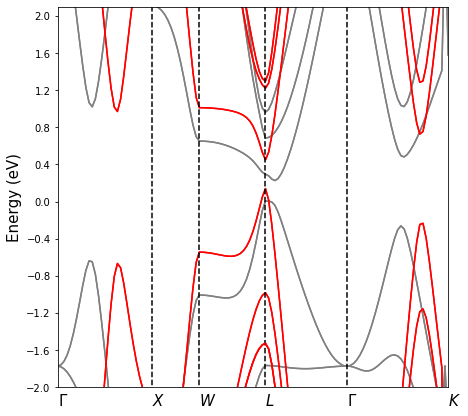

In [28]:
minimum = -0.2

# Generate the plot
fig = plt.figure(figsize = (7,7))

for i in range(matrixsizeLent):
    plt.plot(k_array, energiesLent[i], 'gray', label = "Lent")
for i in range(matrixsizeHsieh):
    plt.plot(k_array, energiesHsieh[i], 'red')
plt.ylabel(r"Energy (eV)", fontsize = 15)
plt.xlim(0, max(k_array))
plt.ylim(np.min(energiesLent) - 1,np.max(energiesLent) + 1)
plt.ylim(-2, 2.1)
plt.xticks([])
plt.yticks(np.arange(-2, 2.1, 0.4))
plt.text(0, minimum - 2, '$\Gamma$', fontsize = 15)
plt.text(k_array[int(stepsize)], minimum - 2, '$X$', fontsize = 15)
plt.text(k_array[int(stepsize*3/2)], minimum - 2, '$W$', fontsize = 15)
plt.text(k_array[int((3/2 + 1/np.sqrt(2))*stepsize)], minimum - 2, '$L$', fontsize = 15)
plt.text(k_array[int((3/2 + 1/np.sqrt(2) + np.sqrt(3)/2)*stepsize)], minimum - 2, '$\Gamma$', fontsize = 15)
plt.text(k_array[len(k_array) - 1], minimum - 2, '$K$', fontsize = 15)
plt.plot(X_list, _list, color = 'black', linestyle = 'dashed')
plt.plot(W_list, _list, color = 'black', linestyle = 'dashed')
plt.plot(L_list, _list, color = 'black', linestyle = 'dashed')
plt.plot(G_list, _list, color = 'black', linestyle = 'dashed')
plt.plot(k_array, energiesHsieh[0], 'red', label = "Hsieh")
plt.plot(k_array, energiesLent[0], 'gray', label = "Lent")
plt.show()

#fig.savefig('C:/Users/pimke/Documents/TUe/2020-2021/Master Thesis/Thesis/Figures/Python/Fitting_Lent_3n.png')

## Fitting procedure
### One band comparison: top valence band

In [42]:
start = time.time()

def Eig(kx_mat, ky_mat, kz_mat, param):
    energyHsieh = np.zeros((matrixsizeHsieh, kx_mat.shape[0]))      
    for i in range(len(kx_array)):
        kx = kx_mat[0][i][0]
        ky = ky_mat[i][0][0]
        kz = kz_mat[0][0][i]
        for j in range(matrixsizeHsieh):
            energyHsieh[j][i] = LA.eigvalsh(Hsieh(kx, ky, kz, param[0], param[1], param[2], param[3], param[4], 0, 0, 0, 0, 1, param[5], param[6]))[j]
    return energyHsieh # The bands from Hsieh to be compared with Lent

mSn = -1.65
mTe = 1.65
tSn = -0.5
tTe = 0.5
t = 0.9
lambdaSn = 0.3
lambdaTe = 0.3
fit_Hsieh = mSn, mTe, tSn, tTe, t, lambdaSn, lambdaTe # fitting parameters from Hsieh

kx_ar = kx_array
ky_ar = ky_array
kz_ar = kz_array

# Lent[9] = Hsieh[5]; Lent[10] = Hsieh[6]

gridx, gridy, gridz = np.meshgrid(kx_ar, ky_ar, kz_ar) # Meshgrid kx, ky, kz
test = energiesLent[9]
test_ = energiesLent[10]


def fun(param): # The function to be minimized. Computes the square of the differences, elementwise. Only max valence band
    return np.square(Eig(gridx, gridy, gridz, param)[5] - energiesLent[9]) 


p0 = -1., 0., 0.5, 0.5, 1.5, 0.3, 0.3 # Test parameters to start from. These are mSn, mTe, tSn, tTe and t

res = least_squares(fun, p0, bounds = (-3, 3)) # Least square function

fit = res.x
print("mSn = ", fit[0], "mTe =", fit[1], "tSn =", fit[2], "tTe =", fit[3], "t =", fit[4], "\u03BBSn =", fit[5], "\u03BBTe =", fit[6])
print("Sum of differences =", np.sum(fun(fit)))
end = time.time()
print("elapsed time =", end - start, "s")

mSn =  -1.2412398692419722 mTe = 2.9306751057505314 tSn = 0.6101799828630541 tTe = -0.06546017736230086 t = 2.414105660751027 λSn = 0.29612297596613635 λTe = 2.9999999999999956
Sum of differences = 3.317739570546466
elapsed time = 62.67938423156738 s


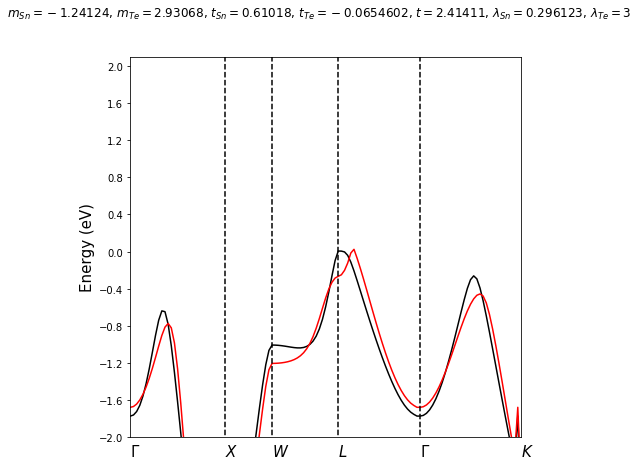

In [43]:
fig = plt.figure(figsize = (7,7))


plt.plot(k_array, test, 'black', label = "Lent")
plt.plot(k_array, Eig(gridx,gridy, gridz, fit)[5], 'red', label = "Fitted Hsieh")
plt.suptitle(r'$m_{Sn} = %g$, $m_{Te} = %g$, $t_{Sn} = %g$, $t_{Te} = %g$, $t = %g$, $\lambda_{Sn} = %g$, $\lambda_{Te} = %g$' % (
        fit[0], fit[1], fit[2], fit[3], fit[4], fit[5], fit[6]), fontsize = 12)
plt.ylabel(r"Energy (eV)", fontsize = 15)
plt.xlim(0, max(k_array))
plt.ylim(np.min(energiesLent) - 1,np.max(energiesLent) + 1)
plt.ylim(-2, 2.1)
plt.xticks([])
plt.yticks(np.arange(-2, 2.1, 0.4))
plt.text(0, minimum - 2, '$\Gamma$', fontsize = 15)
plt.text(k_array[int(stepsize)], minimum - 2, '$X$', fontsize = 15)
plt.text(k_array[int(stepsize*3/2)], minimum - 2, '$W$', fontsize = 15)
plt.text(k_array[int((3/2 + 1/np.sqrt(2))*stepsize)], minimum - 2, '$L$', fontsize = 15)
plt.text(k_array[int((3/2 + 1/np.sqrt(2) + np.sqrt(3)/2)*stepsize)], minimum - 2, '$\Gamma$', fontsize = 15)
plt.text(k_array[len(k_array) - 1], minimum - 2, '$K$', fontsize = 15)
plt.plot(X_list, _list, color = 'black', linestyle = 'dashed')
plt.plot(W_list, _list, color = 'black', linestyle = 'dashed')
plt.plot(L_list, _list, color = 'black', linestyle = 'dashed')
plt.plot(G_list, _list, color = 'black', linestyle = 'dashed')
plt.show()

### Two band comparison: top valence band & bottom conduction band

In [45]:
start = time.time()

def Eig(kx_mat, ky_mat, kz_mat, param):
    energyHsieh = np.zeros((matrixsizeHsieh, kx_mat.shape[0]))      
    for i in range(len(kx_array)):
        kx = kx_mat[0][i][0]
        ky = ky_mat[i][0][0]
        kz = kz_mat[0][0][i]
        for j in range(matrixsizeHsieh):
            energyHsieh[j][i] = LA.eigvalsh(Hsieh(kx, ky, kz, param[0], param[1], param[2], param[3], param[4], 0, 0, 0, 0, 1, param[5], param[6]))[j]
    return energyHsieh # The band from Hsieh to be compared with Lent

mSn = -1.65
mTe = 1.65
tSn = -0.5
tTe = 0.5
t = 0.9
fit_Hsieh = mSn, mTe, tSn, tTe, t, lambdaSn, lambdaTe # Parameters from Hsieh

kx_ar = kx_array
ky_ar = ky_array
kz_ar = kz_array


# Hsieh[0] = Lent[4]
# Hsieh[5]; Lent[9]
# Gap
# Hsieh[6] = Lent[10]
# Hsieh[11] = Lent[15]

gridx, gridy, gridz = np.meshgrid(kx_ar, ky_ar, kz_ar)

def fun(param): # It now compares two band with each other. The max valence band and the min conduction band.
    return (
    np.add(np.square(Eig(gridx, gridy, gridz, param)[5] - energiesLent[9]),
    np.square(Eig(gridx, gridy, gridz, param)[6] - energiesLent[10]))
    )
#np.sum(np.square(Eig(gridx, gridy, gridz, param)[7] - energiesLent[11]))
#np.sum(np.square(Eig(gridx, gridy, gridz, param)[4] - energiesLent[8])) +

p0 = -1., 0., 0.5, 0.5, 1.5, 0.3, 0.3 # Test parameters to start from. These are mSn, mTe, tSn, tTe, t, lambdaSn and lambdaTe

res = least_squares(fun, p0, bounds = (-3, 3))
fit = res.x
print("mSn = ", fit[0], "mTe =", fit[1], "tSn =", fit[2], "tTe =", fit[3], "t =", fit[4], "\u03BBSn =", fit[5], "\u03BBTe =", fit[6])
print("Sum of squares of differences =", np.sum(fun(fit)))
end = time.time()
print("elapsed time =", end - start, "s")

KeyboardInterrupt: 

In [40]:
start = time.time()

def fun(param):
    return (
    np.sum(np.square(Eig(gridx, gridy, gridz, param)[5] - energiesLent[9])) +
    np.sum(np.square(Eig(gridx, gridy, gridz, param)[6] - energiesLent[10]))
    )

print(fun(fit_Hsieh))
end = time.time()
print("elapsed time =", end - start, "s")

290.67868468695474
elapsed time = 1.1567151546478271 s


In [39]:
start = time.time()

def fun(param):
    return np.sum(np.square(Eig(gridx, gridy, gridz, param)[5] - energiesLent[9]))

print(fun(fit_Hsieh))
end = time.time()
print("elapsed time =", end - start, "s")

223.6454987695416
elapsed time = 0.5752642154693604 s


In [33]:
def fun_separate(param):
    return (
    np.sum(Eig(gridx, gridy, gridz, param)[4] - energiesLent[8]) +
    np.sum(Eig(gridx, gridy, gridz, param)[5] - energiesLent[9]) +
    np.sum(Eig(gridx, gridy, gridz, param)[6] - energiesLent[10]) +
    np.sum(Eig(gridx, gridy, gridz, param)[7] - energiesLent[11])
    )

print(fun_separate(fit_Hsieh))

-15.801914970946768


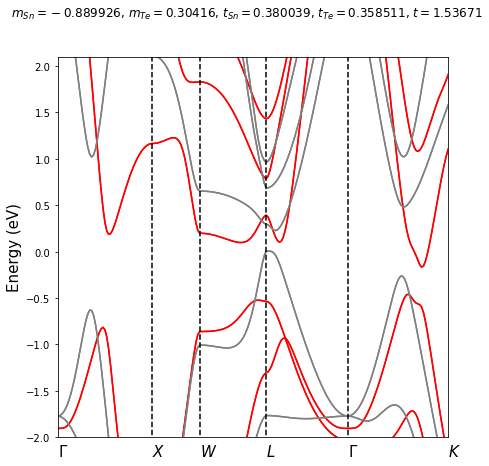

In [119]:
fig = plt.figure(figsize = (7,7))

for i in range(matrixsizeHsieh):
    plt.plot(k_array, Eig(gridx, gridy, gridz, fit)[i], 'red')
for i in range(matrixsizeLent):
    plt.plot(k_array, energiesLent[i], 'gray')
plt.ylabel(r"Energy (eV)", fontsize = 15)
plt.xlim(0, max(k_array))
plt.ylim(np.min(energiesLent) - 1,np.max(energiesLent) + 1)
plt.ylim(-2, 2.1)
plt.xticks([])
plt.yticks(np.arange(-2, 2.1, 0.5))
plt.text(0, minimum - 2, '$\Gamma$', fontsize = 15)
plt.text(k_array[int(stepsize)], minimum - 2, '$X$', fontsize = 15)
plt.text(k_array[int(stepsize*3/2)], minimum - 2, '$W$', fontsize = 15)
plt.text(k_array[int((3/2 + 1/np.sqrt(2))*stepsize)], minimum - 2, '$L$', fontsize = 15)
plt.text(k_array[int((3/2 + 1/np.sqrt(2) + np.sqrt(3)/2)*stepsize)], minimum - 2, '$\Gamma$', fontsize = 15)
plt.text(k_array[len(k_array) - 1], minimum - 2, '$K$', fontsize = 15)
plt.plot(X_list, _list, color = 'black', linestyle = 'dashed')
plt.plot(W_list, _list, color = 'black', linestyle = 'dashed')
plt.plot(L_list, _list, color = 'black', linestyle = 'dashed')
plt.plot(G_list, _list, color = 'black', linestyle = 'dashed')
plt.suptitle(r'$m_{Sn} = %g$, $m_{Te} = %g$, $t_{Sn} = %g$, $t_{Te} = %g$, $t = %g$, $\lambda_{Sn} = %g$, $\lambda_{Te} = %g$' % (
        fit[0], fit[1], fit[2], fit[3], fit[4], fit[5], fit[6]), fontsize = 12)
plt.show()

#fig.savefig('C:/Users/pimke/Documents/TUe/2020-2021/Master Thesis/Thesis/Figures/Python/Fitting_Lent_5,9.png')